In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# set print precision
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# matplotlib style
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-notebook')

In [34]:
# load train data to build model
df_initial = pd.read_csv('data/data_initial.csv')
print(df_initial.dtypes)

df = pd.read_csv('data/train.csv')
df = df.drop(columns='type')

df.dtypes




category                 object
rating                  float64
reviews                   int64
installs                  int64
type                     object
price                   float64
content_rating           object
app_size                float64
last_updated_encoded      int64
dtype: object


category                 object
rating                  float64
reviews                 float64
installs                float64
price                   float64
content_rating           object
app_size                float64
last_updated_encoded      int64
dtype: object

# Initial model fit with all variables

In [32]:
# regress rating against all other variables
ystr = 'rating'
x_var = [col for col in df.columns if col != ystr]
xstr = '+'.join(x_var)

# build initial ols model 
model = smf.ols(f'{ystr}~{xstr}', data=df).fit()

print(model.summary())
# print(model_drop.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.045
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           7.24e-08
Time:                        15:18:01   Log-Likelihood:                -342.85
No. Observations:                 432   AIC:                             711.7
Df Residuals:                     419   BIC:                             764.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## Multicolinearity

In [4]:
numeric_x_var = df[x_var].select_dtypes(np.number)
X = sm.add_constant(numeric_x_var)
vif = pd.DataFrame([variance_inflation_factor(X.values, i) \
                    for i in range(X.shape[1])], 
                   index=['intercept'] + list(X.columns[1:].str.lower()),
                   columns=['vif'])
print(vif)

                          vif
intercept            35.76591
reviews               7.72008
installs              7.77584
price                 1.03787
app_size              1.11017
last_updated_encoded  1.08286


# Best subsets adhj-R, Cp, AIC/BIC

In [5]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def dummy2cat(vars):
    output = []
    cat = 0
    type_var = 0
    content = 0
    for var in vars:
        if any([cat_var in var for cat_var in ['category','content_rating', 'type']]):
            if cat == 0:
                output.append('category')
                cat = 1
            elif type_var == 0:
                output.append('type')
                type_var = 1
            elif content == 0:
                output.append('content')
                content = 1
        else:
            output.append(var)
    return var
            
subsets = list(powerset(x_var))[1:]
subsets_ols = [f"{ystr}~{'+'.join(sub)}" for sub in subsets]
models = [smf.ols(sub, data=df).fit() for sub in subsets_ols]


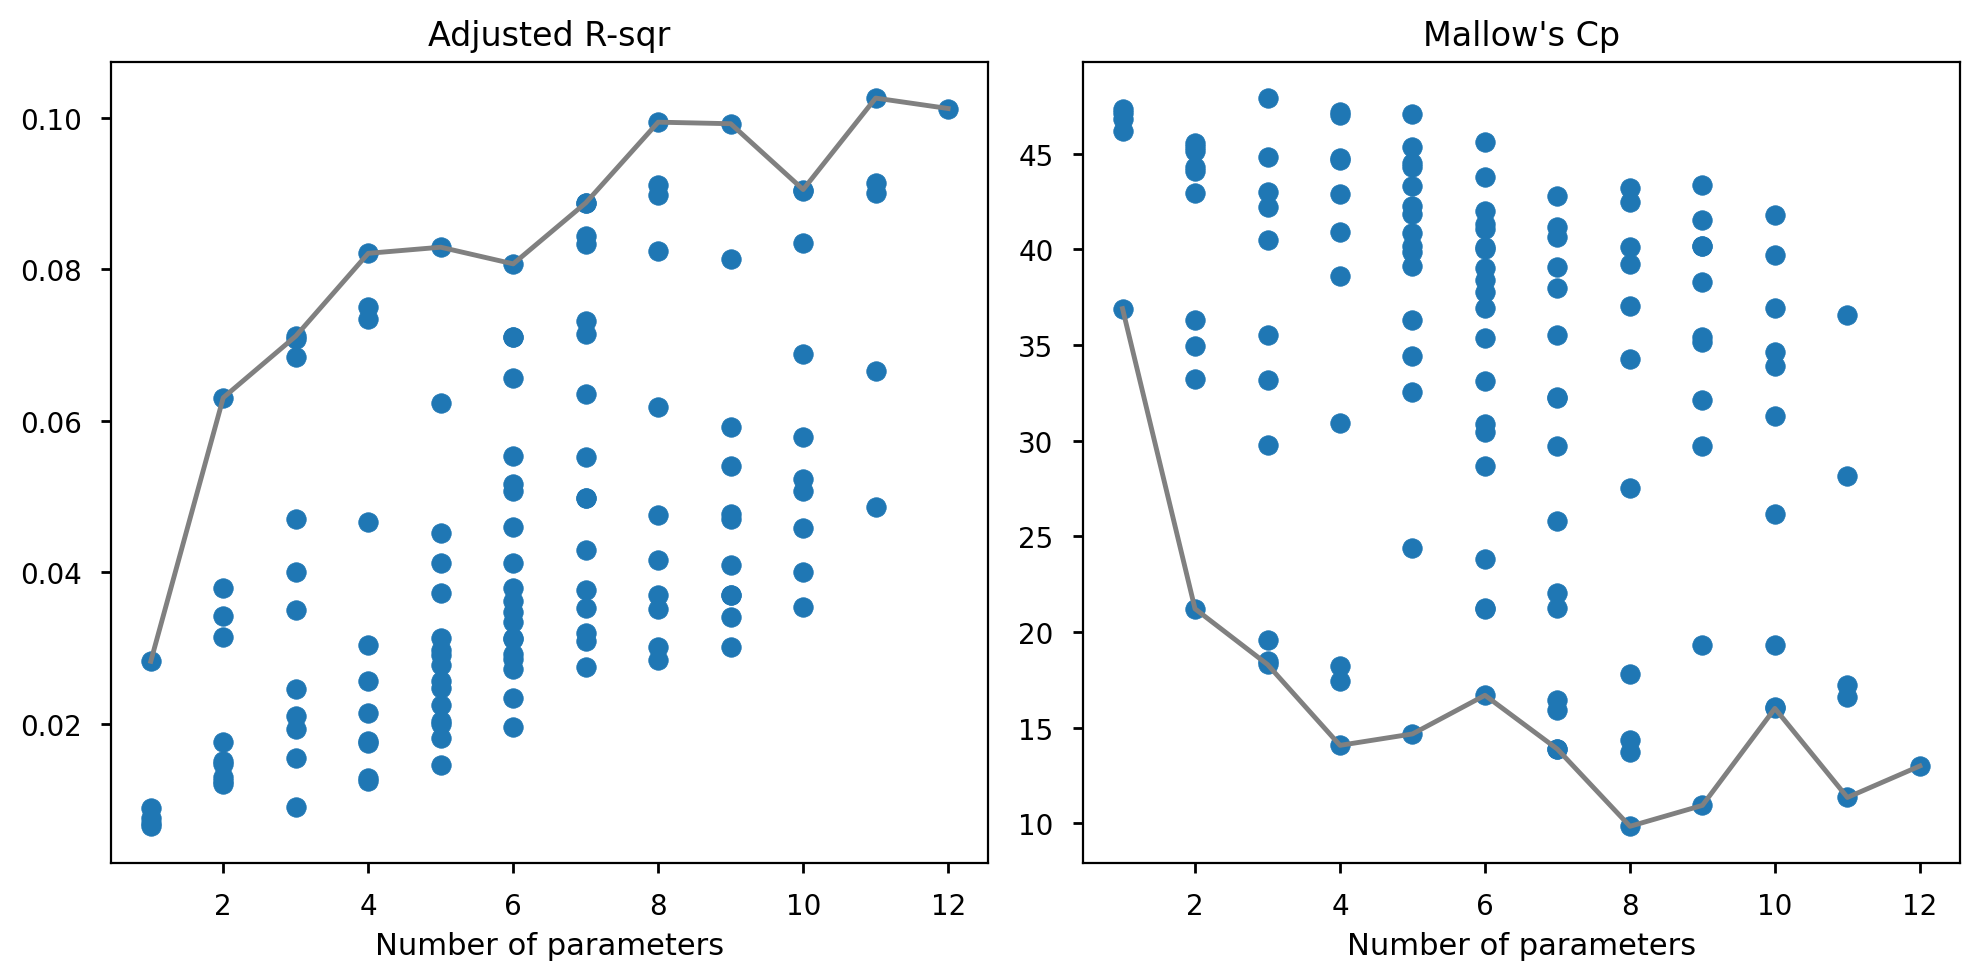

     Vars                                                                          Predictors  Adjusted R-sqr  Mallow's Cp
100     8                            category, reviews, installs, price, last_updated_encoded         0.09942      9.84766
121     9                  category, reviews, installs, price, app_size, last_updated_encoded         0.09922     10.94134
98     10                                  category, reviews, installs, price, content_rating         0.09053     16.00865
120    11            category, reviews, installs, price, content_rating, last_updated_encoded         0.10260     11.35612
126    12  category, reviews, installs, price, content_rating, app_size, last_updated_encoded         0.10122     13.00000


In [6]:
# rsqr mallow
full_mse = models[-1].mse_resid
mallow = lambda reduced:  np.sum(np.power(reduced.resid, 2)) / full_mse - (len(df) - 2*len(reduced.params))
stat = [np.array([model.rsquared_adj, mallow(model)]) for model in models]
rcp = []
for i, (r, mcp) in enumerate(stat):
    var_nums = len(models[i].params)-1
    predictors = ", ".join(subsets[i])
    rcp.append([var_nums, predictors, r, mcp])

rcp_df = pd.DataFrame(data=rcp, columns=['Vars', 'Predictors','Adjusted R-sqr', "Mallow's Cp"])
rcp_best = rcp_df.groupby('Vars').agg({'Adjusted R-sqr':np.max, "Mallow's Cp": np.min}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,5)) 
axes = np.array(axes).flatten()

for i, ax in enumerate(axes):
    data = rcp_df[['Adjusted R-sqr', "Mallow's Cp"]]
    ax.scatter(rcp_df.Vars, data.iloc[:,i])
    ax.plot(rcp_best.Vars, rcp_best.iloc[:,i+1], color='grey')
    ax.set_title(data.columns[i])
    ax.set_xlabel('Number of parameters')

    
plt.tight_layout()
plt.show()

top4 = rcp_best[rcp_best.Vars >= 8]

candidate = rcp_df[(rcp_df['Adjusted R-sqr'].isin(top4['Adjusted R-sqr'])) | (rcp_df["Mallow's Cp"].isin(top4["Mallow's Cp"]))].sort_values(by='Vars')
print(candidate.to_string())

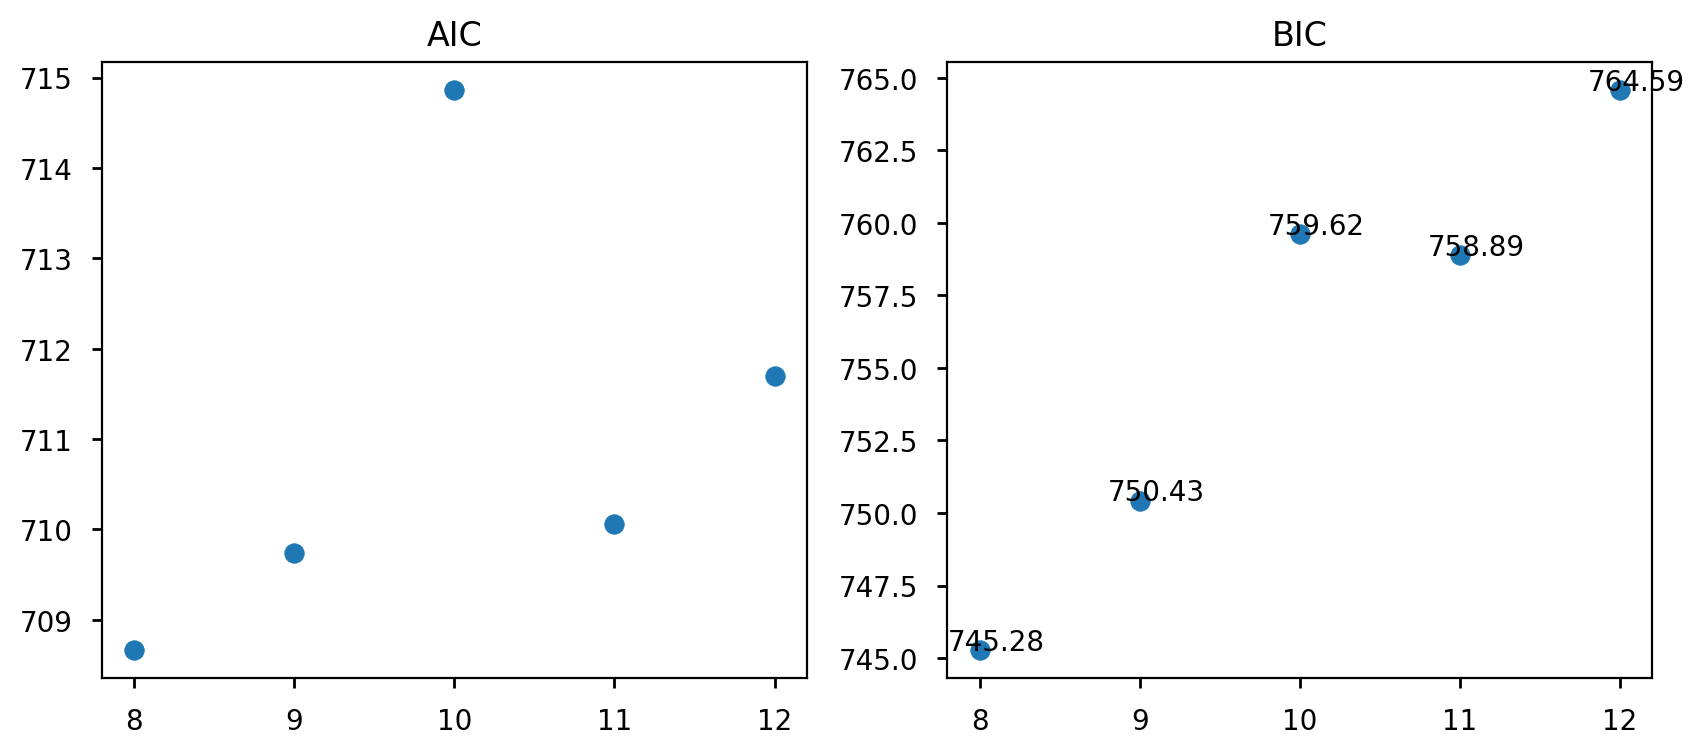

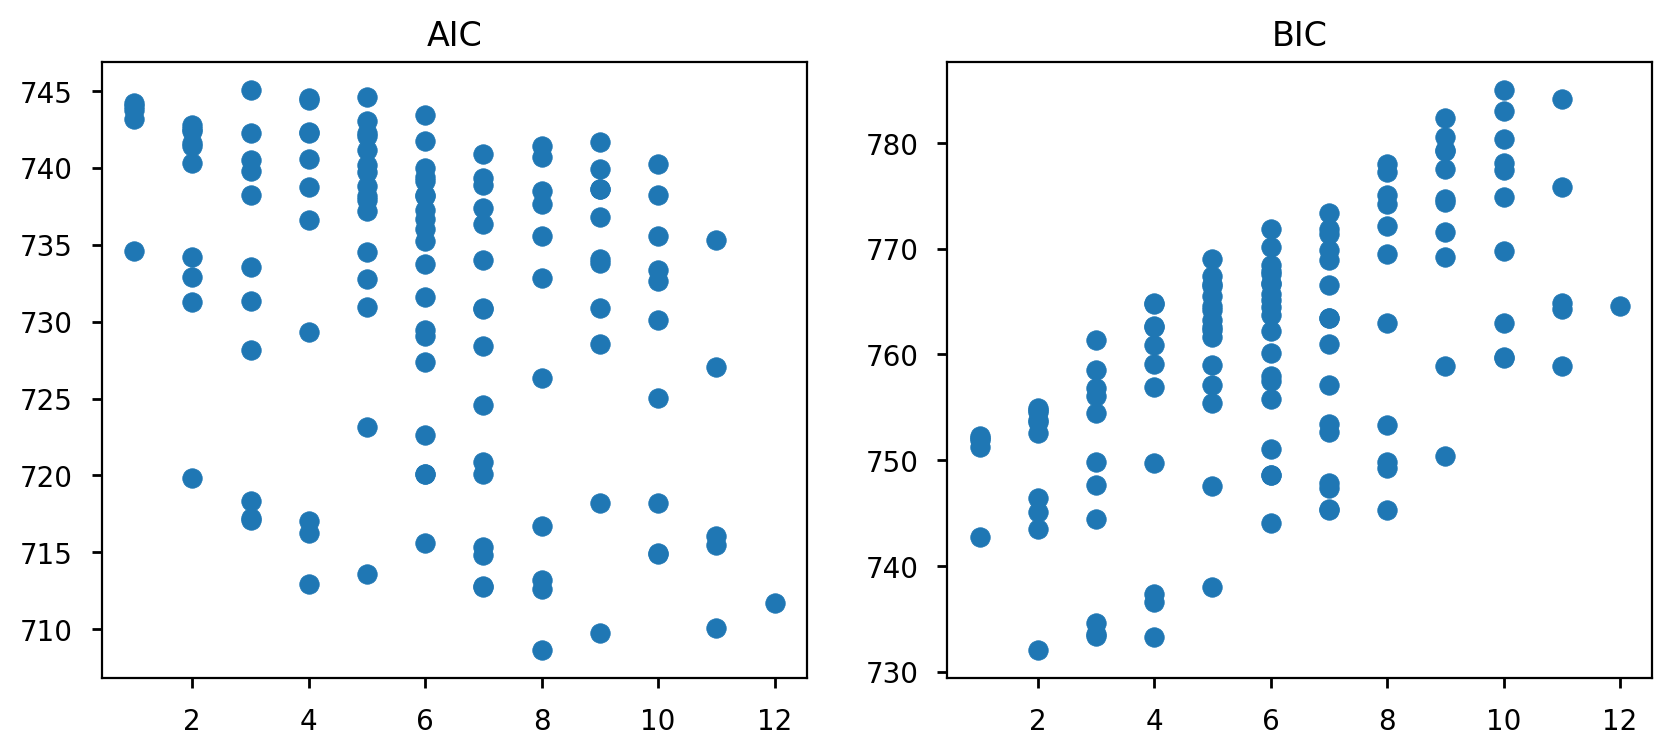

In [31]:
### aic bic
aicbic=[]
candidate_models = [ models[subsets.index(tuple(c.split(', ')))] for c in candidate.Predictors]
cand_aicbic = [(len(model.params)-1, model.aic, model.bic) for model in candidate_models]
aicbic_df = pd.DataFrame(data=cand_aicbic, columns=['Vars','AIC', 'BIC'])



fig, ax = plt.subplots(1,2,figsize = (10,4))

ax[0].scatter(aicbic_df.Vars, aicbic_df['AIC'])
ax[0].set_title('AIC')
ax[1].scatter(aicbic_df.Vars, aicbic_df['BIC'])
ax[1].set_title('BIC')

for i, txt in enumerate(aicbic_df['AIC']):
    ax[0].annotate(np.round(txt,2), (aicbic_df.Vars[i]-0.2, aicbic_df['BIC'][i]+0.), )

plt.show()

ic_vals = [(model.aic, model.bic) for model in models]

for i, (aic, bic) in enumerate(ic_vals):
    var_nums = len(models[i].params)-1
    predictors = ", ".join(subsets[i])
    aicbic.append([var_nums, predictors, aic, bic])
    
aicbic_df = pd.DataFrame(data=aicbic, columns=['Vars', 'Predictors','aic', 'bic'])

fig, ax = plt.subplots(1,2,figsize = (10,4))

ax[0].scatter(aicbic_df.Vars, aicbic_df['aic'])
ax[0].set_title('AIC')
ax[1].scatter(aicbic_df.Vars, aicbic_df['bic'])
ax[1].set_title('BIC')

plt.show()


# aicbic_df.sort_values(by='bic')

In [152]:
best = 'category, reviews, installs, price, last_updated_encoded'.split(',')
ystr = 'rating'
x_var = best
xstr = '+'.join(x_var)

# build initial ols model 
final = smf.ols(f'{ystr}~{xstr}', data=df).fit()

print(final.summary())

# The partial and sequential anova to re-confirm the t- test values
partial = sm.stats.anova_lm(final, typ=2)

print('\n~~~~~~~ Partial ANOVA ~~~~~~~')
print(partial)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     6.948
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           1.30e-08
Time:                        15:54:50   Log-Likelihood:                -345.33
No. Observations:                 432   AIC:                             708.7
Df Residuals:                     423   BIC:                             745.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

# Prediction


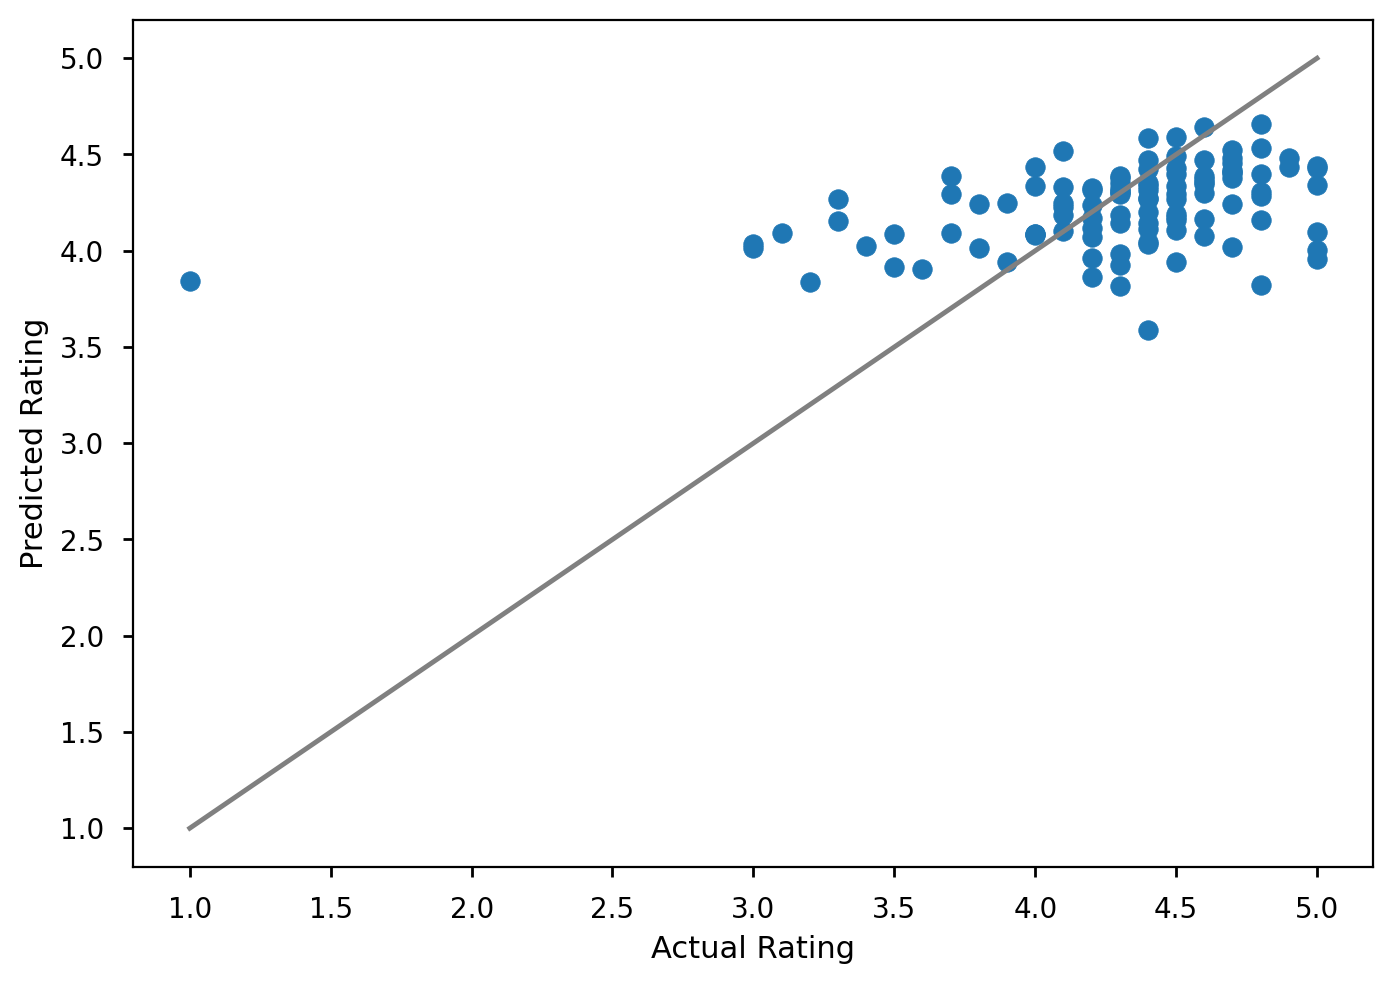

0.2776901927535762 0.25454934335744483 0.15226532444751772


In [149]:
from sklearn import metrics
test = pd.read_csv('data/test.csv')
test = test.drop(columns='type')

test_x = smf.ols(f'{ystr}~{xstr}', data=test).exog


predicted = final.predict(test_x, transform=False)
actual = np.array(test.rating)
n = len(test_x)
p = len(final.params)

mse = sum( (actual- predicted) ** 2 )  / (n - p) 
adj_r = 1 - (n-1)/(n-p)

# plot graph
plt.scatter(actual, predicted)
plt.plot([1,5],[1,5], color='grey')
plt.ylabel('Predicted Rating')
plt.xlabel('Actual Rating')
plt.show()

print(mse, metrics.mean_squared_error(actual, predicted), metrics.r2_score(actual, predicted))  

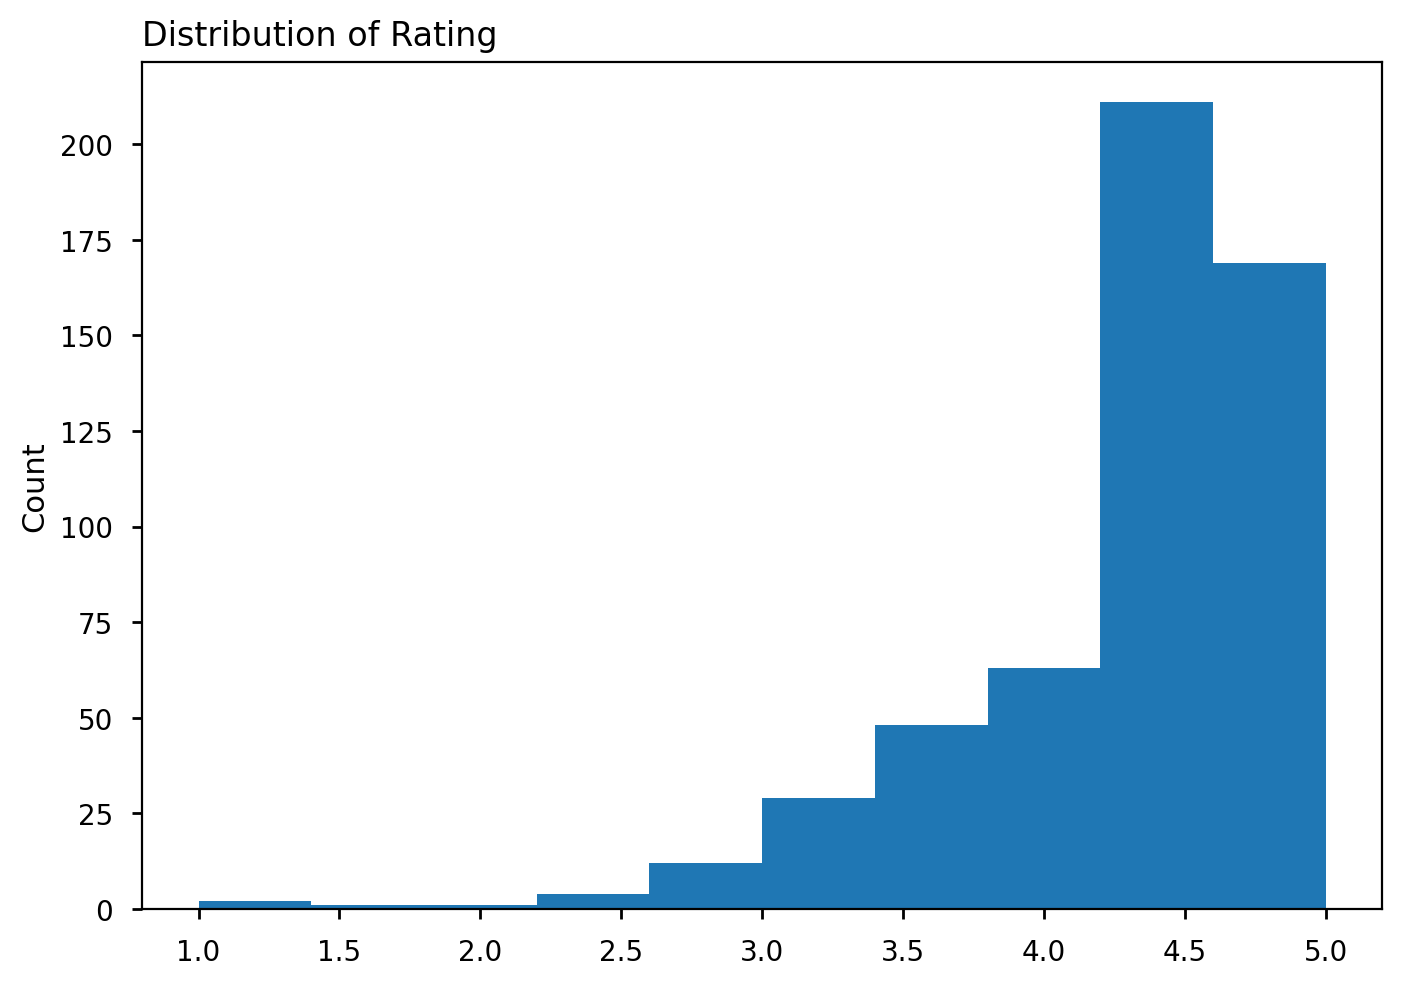

In [128]:
together = pd.concat([df, test])
plt.hist(together.rating)

# plt.hist(df.rating)
plt.ylabel('Count')
plt.title('Distribution of Rating', loc='left')
plt.show()

